In [58]:
# libraries for data analysis and wrangling
import pandas as pd
import numpy as np

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
sns.set_style(style='whitegrid')

# libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [59]:
# import train data set
df = pd.read_csv('train.csv')

# import test data set (unlabeled) - to be used as final test for kaggle competition (https://www.kaggle.com/c/titanic/)
df_competition = pd.read_csv('test.csv')

# view data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
# view data properties
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


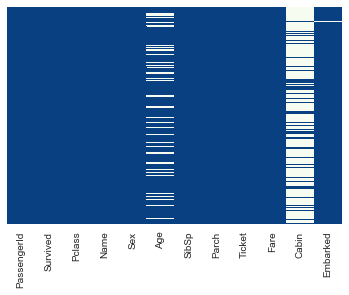

In [61]:
# visualizing missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='GnBu_r')

Total observations are 891 or 40% of the number of passengers on board the Titanic (2,224).

Predictor 'Age' and 'Cabin' have missing values. 'Age' has only roughly 20% of values missing (177 out of 891) which can be imputed based on existing values.
For the 'Cabin' variable there is no possible way to impute the missing values, as roughtly 80% are missing (687 out of 891). This is due to the fact that only 1st class passengers have had dedicated cabins, all others were therefore coded as 'unknown'. A meaningful interpretation of this predictor does not seem suitable and will be dropped.

'Sex' and 'Embarked' values are categorical and can be transformed into numerical values using dummy coding in order to be included for the machine learning algorithm. 'Name' can be used to extract the title of the passenger and will be dropped afterwards, as it does not contribute to 'Survival'.

'Ticket' and 'PassengerId' will be dropped as these add no predictive value.

In [62]:
# 'cabin' predictor has roughtly 80% missing values for observations in the train data set 
# cannot be replaced resonably with any kind of imputation and will be dropped
df.drop('Cabin', axis=1, inplace=True)

# drop 'Ticket' and 'PassengerId' column as it cannot be interpreted in a meaningful way
# and / or does not contribute or correlate with survival chance
df.drop(['Ticket', 'PassengerId'], axis=1, inplace=True)

In [63]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Average age was 29.7 years, with the youngest passenger being around 5 month and the oldest at 80 years of age.

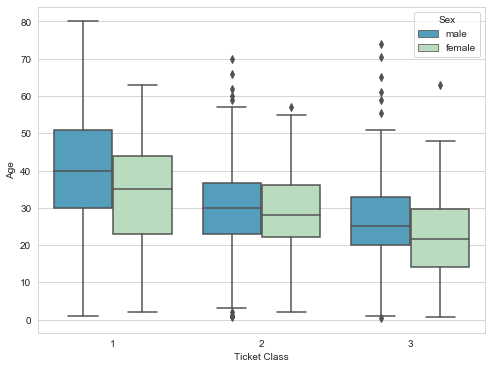

In [64]:
# 'age' predictor has roughly 20% missing values for observations in the train data set
# replacement by imputing based on existing 'age' data, categorized by 'pClass' and 'Sex' 
plt.figure(figsize=(8,6))
sns.boxplot(x='Pclass', y='Age', data=df, palette='GnBu_r', hue='Sex')
plt.xlabel('Ticket Class')
plt.savefig('age-class-sex.png', dpi=300, bbox_inches = "tight")

In [65]:
# get respective mean age for the six different groups
age_class = df.groupby(by=['Pclass', 'Sex'])['Age'].mean()
age_class

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

Difference in mean age by ticket class ('Pclass') and sex can be observed. The higher the class, the older the passengers on average. Furthermore, on average male passengers are older than female passenger over all three ticket classes.

Imputing missing age data per passanger based on his / her ticket class and sex by using mean age of the six different groups (three different classes and both sex respectively).

In [66]:
# write function to impute age per observation based on respective group

def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    sex = cols[2]
    
    if pd.isnull(age):

        if pclass == 1 and sex == 'female':
            return age_class[1][0]

        elif pclass == 1 and sex == 'male':
            return age_class[1][1]

        elif pclass == 2 and sex == 'female':
            return age_class[2][0]
        
        elif pclass == 2 and sex == 'male':
            return age_class[2][1]
        
        elif pclass == 3 and sex == 'female':
            return age_class[3][0]
        
        else:
            return age_class[3][1]

    else:
        return age

# apply impute function to data set
df['Age'] = df[['Age', 'Pclass', 'Sex']].apply(impute_age,axis=1)

The Siblings/Spouse and Parents/Children variable can be used to compute number of family members (family size) traveling with each passenger.

In [67]:
# feature engineering: family size per passenger can be computed by adding 'SibSp' and 'Parch'
df['family_size'] = df['SibSp'] + df['Parch']

As mentioned earlier, the Name variable is used to extract the title for each passenger. Originally, 15 different titles are included with the names. For simplicity and better interpretation, this is reduced to three: 'Mr', 'Mrs' and 'Miss'.

In [68]:
# feature engineering: Title of passenger can be extracted from the 'Name' column

# possible titles
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 'Dr', 'Ms', 'Mlle','Col', 'Capt',
            'Mme', 'Countess', 'Don', 'Jonkheer']

# first, function to extract Title is defined
def title_extract(name):
    for title in title_list:
        if title in name:
            return title
    
# extract title from name using defined function and add as a new column
df['Title'] = df['Name'].apply(title_extract)

# merge different titles to one of 'Mr', 'Mrs' or 'Miss'
def replace_title(cols):    # function to replace title
    title = cols[0]
    sex = cols[1]
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Master']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if sex=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

# apply merging function
df['Title'] = df[['Title', 'Sex']].apply(replace_title, axis=1)

# drop name column after extraction of title
df.drop('Name', axis=1, inplace=True)

Mr      571
Miss    182
Mrs     138
Name: Title, dtype: int64
male      577
female    314
Name: Sex, dtype: int64


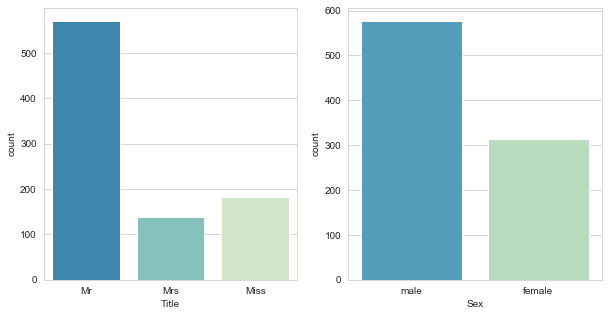

In [69]:
# viewing distribution of 'Mr', 'Mrs' and 'Miss' title
print(df['Title'].value_counts())
print(df['Sex'].value_counts())

f, axes = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(10)
sns.countplot(df['Sex'], palette='GnBu_r', ax=axes[1])
sns.countplot(df['Title'], palette='GnBu_r', ax=axes[0])
plt.savefig('title-sex-distr.png', dpi=300, bbox_inches = "tight")

Most common title is 'Mr' (n=571), which correlates with 577 male passenger on board. The difference in number of 'Mr' titles and male passenger (Δ=6) can be explained through calculation error, which is only 0.7% and therefore not significant. More unmarried female passenger were on board ('Miss') than married female passenger ('Mrs'), with overall 314 female passenger.

In [70]:
# 'Sex', 'Embarked' and 'Title' is transformed using dummy coding in order for the algorithm to be able to interpret the variable
sex_dummy = pd.get_dummies(df['Sex'], drop_first=True)
embarked_dummy = pd.get_dummies(df['Embarked'], drop_first=True)
title_dummy = pd.get_dummies(df['Title'], drop_first=True)

# drop original value and replace by dummy coded values
df_svm = df.copy()
df_svm.drop(['Sex', 'Embarked', 'Title'], axis=1, inplace=True)
df_svm = pd.concat([df_svm, sex_dummy, embarked_dummy, title_dummy], axis=1)

In [71]:
# review current data set after changes are made
df_svm.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,family_size,male,Q,S,Mr,Mrs
0,0,3,22.000000,1,0,7.2500,1,1,0,1,1,0
1,1,1,38.000000,1,0,71.2833,1,0,0,0,0,1
2,1,3,26.000000,0,0,7.9250,0,0,0,1,0,0
3,1,1,35.000000,1,0,53.1000,1,0,0,1,0,1
4,0,3,35.000000,0,0,8.0500,0,1,0,1,1,0
5,0,3,26.507589,0,0,8.4583,0,1,1,0,1,0
6,0,1,54.000000,0,0,51.8625,0,1,0,1,1,0
7,0,3,2.000000,3,1,21.0750,4,1,0,1,1,0
8,1,3,27.000000,0,2,11.1333,2,0,0,1,0,1
9,1,2,14.000000,1,0,30.0708,1,0,0,0,0,1


Mean fare by: Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64


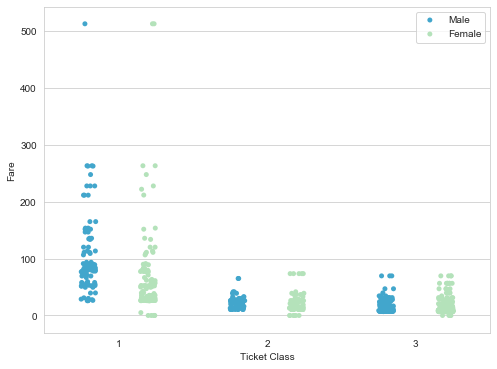

In [72]:
# compare fare with class and sex
print(f'Mean fare by: {df_svm.groupby(["Pclass"])["Fare"].mean()}')

plt.figure(figsize=(8,6))
sns.stripplot(x='Pclass', y='Fare', data=df_svm, hue='male', jitter=True, dodge=True, palette='GnBu_r')
plt.xlabel('Ticket Class')
plt.legend(['Male', 'Female'])
plt.savefig('fare-class.png', dpi=300, bbox_inches = "tight")

Not surprisingly, with 84.2 (dollar) first class was the most expensive on average, with some tickets costing more than $500. Interestingly, some tickets in second and third class were more expensive than in first class. Difference in cost between second and third class, with an average of 20.7 and 13.7 respectively, is less than could be expected.

No significant difference in Fare for male or female passenger can be observed from the strip plot.

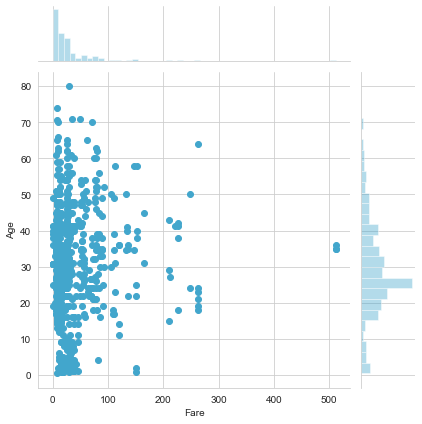

In [73]:
# analyzing fare compared to age
sns.jointplot(df_svm['Fare'], df_svm['Age'], cmap='plasma', kind='scatter', color='#42a6cc')
plt.savefig('fare-age.png', dpi=300, bbox_inches = "tight")

A correlation between age and Fare is not visible when looking at the above jointplot.

----
----

Before using a machine learning algorithms to predict the survival of the passengers, the actual distribution of surviving passengers is analyzed.

Survival count: 
Survived
0    549
1    342
Name: male, dtype: int64

Survival count: 
Survived  male
0         0        81
          1       468
1         0       233
          1       109
Name: male, dtype: int64


([<matplotlib.axis.XTick at 0x26a3bedf7c8>,
 <a list of 2 Text xticklabel objects>)

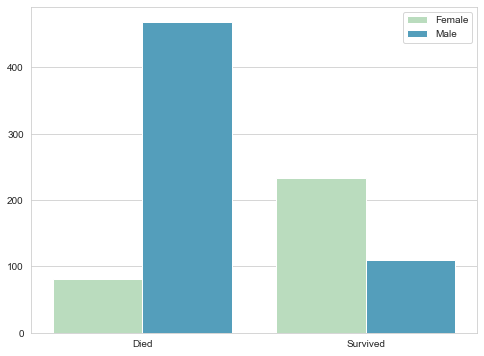

In [74]:
# calculate and visualize survival by sex

print(f'Survival count: \n{df_svm.groupby(["Survived"])["male"].count()}\n')
print(f'Survival count: \n{df_svm.groupby(["Survived", "male"])["male"].count()}')

plt.figure(figsize=(8,6))
sns.countplot('Survived', hue='male', data=df_svm, palette='GnBu')
plt.legend(['Female', 'Male'])
plt.ylabel('')
plt.xlabel('')
plt.xticks((0,1), ('Died', 'Survived'))

342 out of 891 passenger in the data set survived (38.4%). For male passengers, the survival rate was significantly lower (18.9%, 109 out of 577) compared to female passengers (74.2%, 233 out of 314).

Survival count: 
Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Pclass, dtype: int64


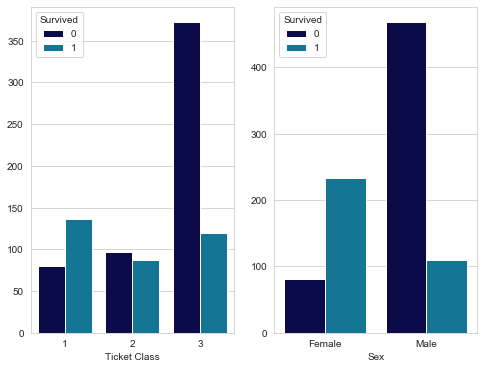

In [75]:
# comparing class and survival rate
print(f'Survival count: \n{df_svm.groupby(["Survived", "Pclass"])["Pclass"].count()}')

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,2,1)     
ax1 = sns.countplot('Pclass', hue='Survived', data=df_svm, palette='ocean')
ax1.set_ylabel('') 
ax1.set_xlabel('Ticket Class') 
      
ax2 = fig.add_subplot(1,2,2)      
ax2 = sns.countplot('male', hue='Survived', data=df_svm, palette='ocean')
ax2.set_ylabel('')
ax2.set_xlabel('Sex') 
ax2.set_xticklabels(['Female', 'Male'])

plt.savefig('survival-sex-class.png', dpi=300, bbox_inches = "tight")

In third class, 3 out of 4  passenger (75.8%, 373 out of 491) died. This is significantly higher than in second and first class, where 52.7% (97 out of 184) of second class and "only" 37.0% (80 out of 216) of first class passenger died.

In [76]:
# comparing class and title by survival rate using a heatmap
df_heatm = df[['Title', 'Pclass', 'Survived']].copy()
df_heatm = pd.pivot_table(df_heatm, values='Survived', index='Pclass', columns=['Title'], aggfunc=np.mean)
df_heatm

Title,Miss,Mr,Mrs
Pclass,,,
1,0.957447,0.364407,0.941176
2,0.969697,0.160377,0.844444
3,0.500000,0.135447,0.500000


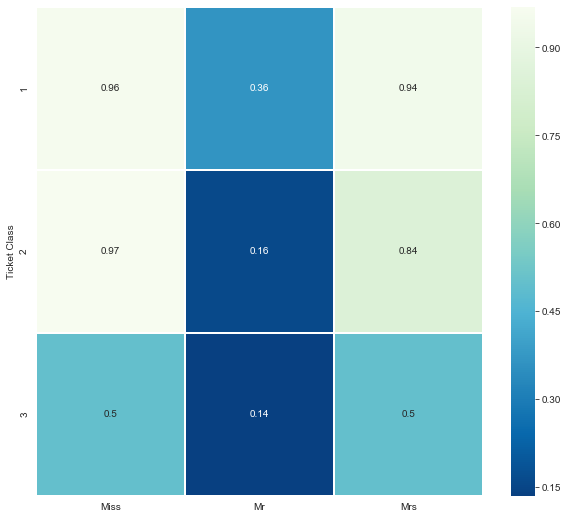

In [77]:
fig = plt.figure(figsize=(10,9))
sns.heatmap(df_heatm, annot=True, linecolor='white', linewidth=1, cmap='GnBu_r')

# fix for mpl bug that cuts off top/bottom of seaborn heatmap
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# plt.xticks((0.5,1.5,2.5),('Mr', 'Mrs', 'Miss'))
plt.xlabel('')
plt.ylabel('Ticket Class')

plt.savefig('heatmap_survival-title-class.png', dpi=300, bbox_inches = "tight")

Comparing survival rate based on ticket class and title results in expected outcomes. The survival rate for male passenger was highest in the the first class (36%), but still worse than for any of the female passenger groups. Highest survival rate can be found in the group of unmarried women in second class, with 97%, and unmarried women in forst class, with 96%.

----

Using the existing variables, the survival of a passenger is now predicted using a Support Vector Classifier.

In [78]:
df_svm.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,family_size,male,Q,S,Mr,Mrs
0,0,3,22.0,1,0,7.2500,1,1,0,1,1,0
1,1,1,38.0,1,0,71.2833,1,0,0,0,0,1
2,1,3,26.0,0,0,7.9250,0,0,0,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0,1,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,1,1,0


In [79]:
# define predictor (X) and response (y) variable
X = df_svm.drop(['Survived', 'family_size'], axis=1)
y = df_svm['Survived']

In [80]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [81]:
# create parameter grid
param_grid = {'C': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'gamma': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001], 'kernel': ['rbf']} 

# create object and fit to data
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, scoring='accuracy')
grid.fit(X_train,y_train)
print(f'\nBest SVM parameter: {grid.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.5, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ..........

[CV] ...................... C=20, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.5, kernel=rbf .....................................
[CV] ...................... C=20, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.5, kernel=rbf .....................................
[CV] ...................... C=20, gamma=0.5, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=20, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=20, gamma=0.05, kernel=rbf ....................................
[CV] .

[CV] ..................... C=50, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=50, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=50, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=50, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=50, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=50, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.005, kernel=rbf ...................................
[CV] .................... C=50, gamma=0.005, kernel=rbf, total=   0.0s
[CV] C=50, gamma=0.005, kernel=rbf ...................................
[CV] .

[CV] ..................... C=80, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=80, gamma=0.05, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=80, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=80, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=80, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.005, kernel=rbf ...................................
[CV] .................... C=80, gamma=0.005, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.005, kernel=rbf ...................................
[CV] .................... C=80, gamma=0.005, kernel=rbf, total=   0.0s
[CV] C=80, gamma=0.005, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:    3.8s finished


Best SVM parameter:
- C: 90
- gamma: 0.001
- kernel: rbf

In [82]:
# get predictions using test data
grid_predictions = grid.predict(X_test)

# get confusion matrix
print(confusion_matrix(y_test,grid_predictions))
tn, fp, fn, tp = confusion_matrix(y_test, grid_predictions).ravel()
print(f'\nTrue Positive: {tp}')
print(f'False Positive: {fp}')
print(f'True Negative: {tn}')
print(f'False Negative: {fn}\n')

# evaluate model
print(classification_report(y_test,grid_predictions))

[[147  34]
 [ 29  85]]

True Positive: 85
False Positive: 34
True Negative: 147
False Negative: 29

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       181
           1       0.71      0.75      0.73       114

    accuracy                           0.79       295
   macro avg       0.77      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



**With an accuracy of 0.79 the outcome of the tragedy for a passenger in the test data set could be predicted correctly using a Support Vector Machine, which is an significant increase to the null accuracy of 0.62 (accuracy of a model always predicting the most common outcome, i.e. predicting non-survival for all passengers in the current case).**

20 passenger were predicted to survive based on their features, but unfortunately lost their lives (false positive - type I error). On the other hand, 28 passenger were predicted to die but were able to survive (false negative - type II error).

In [83]:
# TODO competition